In [1]:
# Modules
import pickle
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import deque
%matplotlib inline

# Section 1: Camera Calibration

This section presents the method I did camera calibration. I designed a `CameraCalibrator`. During calibrating, it  searches valid chessboard pattens from $9 \times 6$ to $2 \times 2$. The `CameraCalibrator` also offers an `undistort` function to undistort camera images using calibrated matrixes.

---
## 1.1 The Camera Calibrator

The following code cell describes how I design the `CameraCalibrator`.

In [2]:
# Camera calibration

class CameraCalibrator(object):
    
    def __init__(self):
        # Declare calibration matrixes.
        self.mtx = None
        self.dist = None
    
    def _gen_points(self, patten):
        '''Generate object points of one image using given patten.'''
        points = np.zeros((np.multiply(*patten), 3), np.float32)
        points[:, :2] = np.mgrid[0:patten[0], 0:patten[1]].T.reshape(-1, 2)
        return points
    
    def calibrate(self, chessboard_img_path, chessboard_patten=(9, 6), img_size=(1280, 720)):
        # Search pattens that may be smaller than default
        nx, ny = chessboard_patten
        pattens = [(x, y) for x in range(nx, 2, -1) for y in range(ny, 2, -1)]
        # calibrate using all images.
        images = glob.glob(os.path.join(chessboard_img_path, '*.jpg'))
        objpoints = []  # 3D object points of the chessboard.
        imgpoints = []  # 2D corner points in image plane.
        for idx, img_path in enumerate(images):
            img = plt.imread(img_path)
            if (img.shape[1], img.shape[0]) != img_size:
                img = cv2.resize(img, img_size)
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            for patten in pattens:
                ret, corners = cv2.findChessboardCorners(gray, patten, None)
                if ret:
                    points = self._gen_points(patten)
                    objpoints.append(points)
                    imgpoints.append(corners)
                    break
                else:
                    continue
        assert len(imgpoints) > 0, 'No corners found!'
        _, self.mtx, self.dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints,
                                                           img_size, None, None)
        print('Calibration Done!')
    
    def undistort(self, img):
        assert self.mtx is not None, 'Er... No calibration matrix found!'
        return cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
    
    def save_matrix(self, fname='camera_mtx_dist.pk'):
        camera_mtx_dist = {}
        camera_mtx_dist['mtx'] = self.mtx
        camera_mtx_dist['dist'] = self.dist
        with open(fname, 'wb') as f:
            pickle.dump(camera_mtx_dist, f)
        print('Camera calibration mtx and dist saved to {}'.format(fname))
    
    def load_matrix(self, fname):
        with open(fname, 'rb') as f:
            camera_mtx_dist = pickle.load(f)
        self.mtx = camera_mtx_dist['mtx']
        self.dist = camera_mtx_dist['dist']
        print('Camera calibration mtx and dist loaded from {}'.format(fname))

## 1.2 Calibrate chessboard images

Calculate the calibration matrixes using the chessboard images under `camera_cal/` directory.

In [3]:
cc = CameraCalibrator()
cc.calibrate(chessboard_img_path='camera_cal/')
cc.save_matrix()
undistort = cc.undistort  # rename function for easy use.

Calibration Done!
Camera calibration mtx and dist saved to camera_mtx_dist.pk


Here is an example of an undistorted chessboard image. The result seems just right.

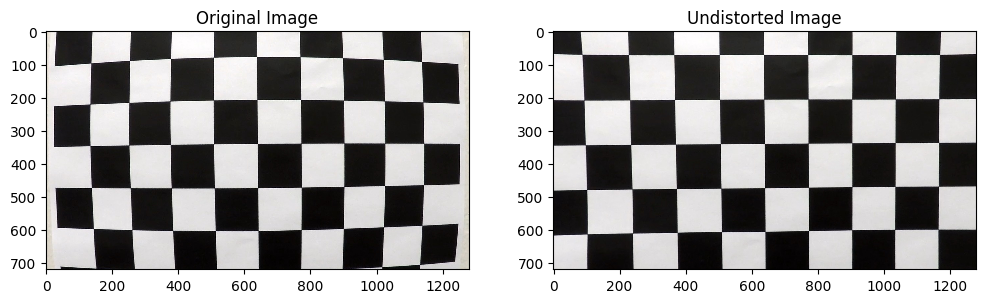

In [4]:
img = plt.imread('camera_cal/calibration1.jpg')
undistorted = undistort(img)
plt.figure(figsize=(12, 4), dpi=100)
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(undistorted)
plt.title('Undistorted Image')
plt.savefig('chessboard_undistortion.jpg')
plt.show()

Here, I applied the `undistort` function to all the test images under `test_images/` directory.

In [5]:
test_img_paths = sorted(glob.glob('test_images/*.jpg'))

for test_img_path in test_img_paths:
    img = plt.imread(test_img_path)
    undist = undistort(img)
    basename = os.path.basename(test_img_path)
    plt.imsave(os.path.join('output_images', basename.split('.')[0]+'_undist.jpg'), undist)

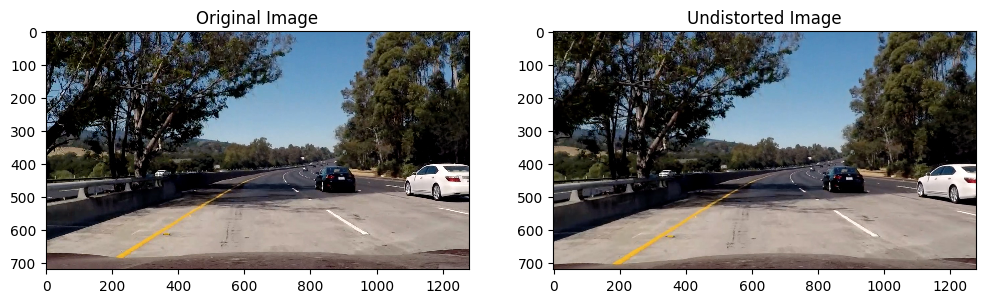

In [6]:
img = plt.imread('test_images/test5.jpg')
img_undist = plt.imread('output_images/test5_undist.jpg')
plt.figure(figsize=(12, 4), dpi=100)
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(img_undist)
plt.title('Undistorted Image')
plt.savefig('undistortion_example.jpg')
plt.show()

# Section 2: Binary Filter for Lane Lines

In this section, I designed a `LaneLineFilter` to extract lane line pixels from a camera image into a binary image. I **spared no effort** in trying to find out the best way to extract line pixels. Finally I got the following tricks:
- **Use LAB color space.** L channel is actually the grayscale of the image, I did sobel gradient calculation on this channel. And B channel actually represents how ***yellow*** the image is, which is perfectly to detect yellow line pixels.
- **Gaussian smooth the absolute sobel gradients.** This to some extent reduces the noise pixels of the sobel results.
- **Take median-value filtering.** For L & B channels, the pixels smaller than their median value are set to the median. This is pretty cool since it filtered some darker but not lane line pixels, making the sobel gradients clean. This is especially useful when processing `challenge_video.mp4`.


---

The following code cell describes how the `LaneLineFilter` is implemented.

In [7]:
class LaneLineFilter(object):
    '''
    A binary filter for lane lines.
    '''
    def __init__(self, sobel_thresh=(20, 100), sobel_kernel=3, sm_kernel=3,
                 l_thresh=170, b_thresh=60):
        self.sobel_thresh = sobel_thresh
        self.sobel_kernel = sobel_kernel
        self.sm_kernel = sm_kernel  # Gaussian smooth kernel size
        # The thresholds of the scaled and median-subtracted L & B channels of LAB color space image.
        self.l_thresh = l_thresh
        self.b_thresh = b_thresh
    
    def _lab_thresh(self, img):
        '''
        Input should be a RGB image array.
        Return is a processed binary of the LAB color space image.
        '''
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        L = lab[:, :, 0]
        B = lab[:, :, 2]
        # Median filtering
        median_L = np.int(np.median(L))
        median_B = np.int(np.median(B))
        L[L < median_L] = median_L
        B[B < median_B] = median_B
        # Calculate line profile gradients for L channel
        sx = cv2.Sobel(L, cv2.CV_32F, 1, 0, ksize=self.sobel_kernel)
        sy = cv2.Sobel(L, cv2.CV_32F, 0, 1, ksize=self.sobel_kernel)
        abs_sx = np.abs(sx)
        abs_sy = np.abs(sy)
        scaled_sx = np.uint8(255 * abs_sx / np.max(abs_sx))
        scaled_sy = np.uint8(255 * abs_sy / np.max(abs_sy))
        # Gaussian smoothing to reduce noises
        scaled_sx = cv2.GaussianBlur(scaled_sx, (self.sm_kernel,)*2, self.sm_kernel)
        scaled_sy = cv2.GaussianBlur(scaled_sy, (self.sm_kernel,)*2, self.sm_kernel)
        # Sobel thresh
        binary = np.zeros_like(scaled_sx)
        min_thresh, max_thresh = self.sobel_thresh
        binary[(scaled_sx > min_thresh) & (scaled_sx <= max_thresh) & \
               (scaled_sy > min_thresh) & (scaled_sy <= max_thresh)] = 1
        # L channel thresh for white color extraction
        # B channel thresh for yellow color extraction
        l_scaled = (L - np.min(L)) * 255.0 / (np.max(L) - np.min(L))
        b_scaled = (B - np.min(B)) * 255.0 / (np.max(B) - np.min(B))
        binary[l_scaled > self.l_thresh] = 1
        binary[b_scaled > self.b_thresh] = 1
        return binary
    
    def apply(self, img):
        return self._lab_thresh(img)

Here is an example binary image of filtered line pixels. The result is pretty cool, without too much noise pixels.

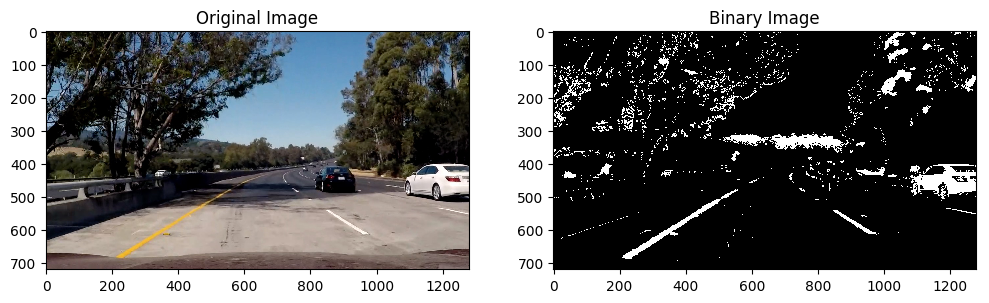

In [8]:
img = plt.imread('test_images/test5.jpg')
llf = LaneLineFilter()
binary = llf.apply(img)
plt.figure(figsize=(12, 4), dpi=100)
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(binary, 'gray')
plt.title('Binary Image')
plt.savefig('binary_example.jpg')
plt.show()

# Section 3: Perspective Warp

I designed a class named `WarpPerspective`, it offers both warp and inverse warp methods. The default source and destination points are (based on image size of 1280\*720):

| src points | dst points |
|:----------:|:----------:|
|  572, 450  |  160,   0  |
|    0, 720  |  160, 720  |
| 1280, 720  | 1120, 720  |
|  702, 450  | 1120,   0  |

**NOTE** The default `src` and `dst` points are set for the images in `test_images/` and `project_video.mp4`.

---
The following is the code implemention.

In [9]:
class WarpPerspective(object):
    
    def __init__(self, src=None, dst=None, img_size=(1280, 720)):
        self.img_size = img_size
        if src is None or dst is None:
            self.src = np.float32(
                [[(img_size[0] / 2) - 68, img_size[1] / 2 + 90],
                 [0, img_size[1]],
                 [img_size[0], img_size[1]],
                 [(img_size[0] / 2) + 62, img_size[1] / 2 + 90]])
            self.dst = np.float32(
                [[img_size[0] / 8, 0],
                 [img_size[0] / 8, img_size[1]],
                 [img_size[0] * 7/8, img_size[1]],
                 [img_size[0] * 7/8, 0]])
        else:
            self.src = np.float32(src)
            self.dst = np.float32(dst)
        # Calculate transform matrix and inverse matrix
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
        self.M_inv = cv2.getPerspectiveTransform(self.dst, self.src)
    
    def warp(self, img):
        '''Warp an image from perspective view to bird view.'''
        assert (img.shape[1], img.shape[0]) == self.img_size, 'Invalid image shape.'
        return cv2.warpPerspective(img, self.M, self.img_size)
    
    def warp_inv(self, img):
        '''Warp inversely an image from bird view to perspective view.'''
        assert (img.shape[1], img.shape[0]) == self.img_size, 'Invalid image shape.'
        return cv2.warpPerspective(img, self.M_inv, self.img_size)

Here is an example of a warped and undistorted image. The warped image shows two parallel straight lines.

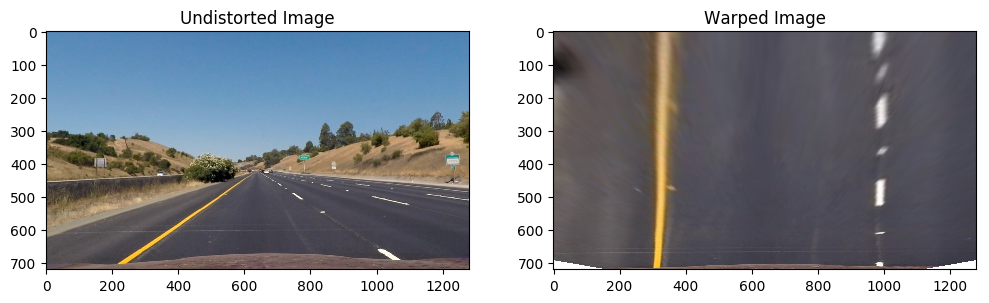

In [10]:
img = plt.imread('output_images/straight_lines1_undist.jpg')
wp = WarpPerspective()
warped = wp.warp(img)
plt.figure(figsize=(12, 4), dpi=100)
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Undistorted Image')
plt.subplot(1, 2, 2)
plt.imshow(warped)
plt.title('Warped Image')
plt.savefig('warp_example.jpg')
plt.show()

# Section 4: Fitting Lane Lines

In this section, I designed a `LaneLineFitTool` collecting several kinds of method locating and fitting lane lines. This is the step right after having a warped and undistorted binary image.

---

The following code cell shows the implemention. It includes line pixel locating methods, fitting methods, visualization methods and calculations of line curve radius and vehicle postion on the road.

In [11]:
class LaneLineFitTool(object):
    '''A collection of methods doing line fitting.'''
    def __init__(self, img_size=(1280, 720), margin=85, area_color=(0, 255, 0),
                 color_left=(255, 0, 0), color_right=(0, 0, 255),
                 xm_per_pix=3.8/700, ym_per_pix=32/720):
        self.img_size = img_size
        self.margin = margin
        self.area_color = area_color
        self.color_left = color_left
        self.color_right = color_right
        self.margin_points = {'l': [], 'r': []}
        # meters per pixel in x, y dimension, based on 2 meter
        self.xm_per_pix = xm_per_pix
        self.ym_per_pix = ym_per_pix
        
    def polyfit(self, xl, yl, xr, yr):
        fit_l = np.polyfit(yl, xl, 2)
        fit_r = np.polyfit(yr, xr, 2)
        return fit_l, fit_r
    
    def line_points_visualize(self, xl, yl, xr, yr, draw_margin=False):
        '''Visualize the located line pixels'''
        shape_x, shape_y = self.img_size
        line_img = np.zeros((shape_y, shape_x, 3)).astype(np.uint8)
        line_img[yl, xl] = list(self.color_left)
        line_img[yr, xr] = list(self.color_right)
        
        if draw_margin:
            margin_points_l = self.margin_points['l']
            margin_points_r = self.margin_points['r']
            if margin_points_l:
                mcolor_l = np.array(self.color_left) + 127
                mcolor_r = np.array(self.color_right) + 127
                mcolor_l[mcolor_l > 255] = 255
                mcolor_r[mcolor_r > 255] = 255
                mcolor_l = tuple(mcolor_l.tolist())
                mcolor_r = tuple(mcolor_r.tolist())
                cv2.polylines(line_img, np.int_([margin_points_l]), True, mcolor_l, 2)
                cv2.polylines(line_img, np.int_([margin_points_r]), True, mcolor_r, 2)
            else:
                print('No margin points defined!')
        
        return line_img
    
    def fit_area_visualize(self, fit_l, fit_r):
        '''Visualize the area between left and right fit lines'''
        shape_x, shape_y = self.img_size
        y_points = np.linspace(0, shape_y - 1, shape_y)
        xfit_l_points = fit_l[0] * y_points ** 2 + fit_l[1] * y_points + fit_l[2]
        xfit_r_points = fit_r[0] * y_points ** 2 + fit_r[1] * y_points + fit_r[2]
        fit_l_points = list(zip(xfit_l_points, y_points))
        fit_r_points = list(zip(xfit_r_points, y_points))
        fit_r_points.reverse()
        fit_points = fit_l_points + fit_r_points
        area_img = np.zeros((shape_y, shape_x, 3)).astype(np.uint8)
        cv2.fillPoly(area_img, np.int_([fit_points]), self.area_color)
        return area_img
    
    def locate_lines_by_blind_search(self, img_binary_warped, nwindows=9, minpix=50,
                                     make_margin_points=False):
        '''
        Blindly search line pixels from an warped binary image.
        Return located lane line pixel indices.
        '''
        shape_y, shape_x = img_binary_warped.shape[:2]
        assert (shape_x,shape_y) == self.img_size, 'Invalid shape.'
        # Histgram of nonzero pixels along y for the bottom part of the image.
        hist = np.sum(img_binary_warped[np.int(shape_y / 2):, :], axis=0)
        # Set base line position.
        midpoint = np.int(shape_x / 2)
        margin = self.margin
        xl_c_base = np.argmax(hist[:midpoint])
        xr_c_base = np.argmax(hist[midpoint:]) + midpoint
        win_height = np.int(shape_y / nwindows)
        xl_c = xl_c_base
        xr_c = xr_c_base
        lane_idxs_l = []
        lane_idxs_r = [] 
        nonzero = img_binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        if make_margin_points:
            margin_points_l_l = []
            margin_points_l_r = []
            margin_points_r_l = []
            margin_points_r_r = []
        
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            y_u = img_binary_warped.shape[0] - (window + 1) * win_height
            y_d = img_binary_warped.shape[0] - window * win_height
            xl_l = xl_c - margin
            xl_r = xl_c + margin
            xr_l = xr_c - margin
            xr_r = xr_c + margin
            # Append margin points
            if make_margin_points:
                margin_points_l_l.append((xl_l, y_d))
                margin_points_l_l.append((xl_l, y_u))
                margin_points_l_r.append((xl_r, y_d))
                margin_points_l_r.append((xl_r, y_u))
                margin_points_r_l.append((xr_l, y_d))
                margin_points_r_l.append((xr_l, y_u))
                margin_points_r_r.append((xr_r, y_d))
                margin_points_r_r.append((xr_r, y_u))
            # Identify the nonzero pixels in x and y within the window
            good_idxs_l = ((nonzeroy >= y_u) & (nonzeroy < y_d) & \
                           (nonzerox >= xl_l) & (nonzerox < xl_r)).nonzero()[0]
            good_idxs_r = ((nonzeroy >= y_u) & (nonzeroy < y_d) & \
                           (nonzerox >= xr_l) & (nonzerox < xr_r)).nonzero()[0]
            # Append these indices to the lists
            lane_idxs_l.append(good_idxs_l)
            lane_idxs_r.append(good_idxs_r)
            # If found > minpix pixels, recenter next window on their mean position
            if len(good_idxs_l) > minpix:
                xl_c = np.int(np.median(nonzerox[good_idxs_l]))
            if len(good_idxs_r) > minpix:        
                xr_c = np.int(np.median(nonzerox[good_idxs_r]))
        
        if make_margin_points:
            margin_points_l_r.reverse()
            margin_points_r_r.reverse()
            self.margin_points['l'] = margin_points_l_l + margin_points_l_r
            self.margin_points['r'] = margin_points_r_l + margin_points_r_r
        
        lane_idxs_l = np.concatenate(lane_idxs_l)
        lane_idxs_r = np.concatenate(lane_idxs_r)

        xl = nonzerox[lane_idxs_l]
        yl = nonzeroy[lane_idxs_l] 
        xr = nonzerox[lane_idxs_r]
        yr = nonzeroy[lane_idxs_r]
        
        return xl, yl, xr, yr
    
    def locate_lines_by_fit_margin(self, img_binary_warped, fit_l, fit_r,
                                   make_margin_points=False):
        '''
        Search line pixels from an warped binary image
        using previous fitting params with a margin.
        
        Return located lane line pixel indices.
        '''
        shape_y, shape_x = img_binary_warped.shape[:2]
        assert (shape_x,shape_y) == self.img_size, 'Invalid shape.'
        margin = self.margin
        
        if make_margin_points:
            y_points = np.linspace(0, shape_y - 1, shape_y)
            xfit_l_points = fit_l[0] * y_points ** 2 + fit_l[1] * y_points + fit_l[2]
            xfit_r_points = fit_r[0] * y_points ** 2 + fit_r[1] * y_points + fit_r[2]
            margin_points_l_l = list(zip(xfit_l_points - margin, y_points))
            margin_points_l_r = list(zip(xfit_l_points + margin, y_points))
            margin_points_l_r.reverse()
            margin_points_r_l = list(zip(xfit_r_points - margin, y_points))
            margin_points_r_r = list(zip(xfit_r_points + margin, y_points))
            margin_points_r_r.reverse()
            self.margin_points['l'] = margin_points_l_l + margin_points_l_r
            self.margin_points['r'] = margin_points_r_l + margin_points_r_r

        nonzero = img_binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        xfity_l_points = fit_l[0] * nonzeroy ** 2 + fit_l[1] * nonzeroy + fit_l[2]
        xfity_r_points = fit_r[0] * nonzeroy ** 2 + fit_r[1] * nonzeroy + fit_r[2]
        
        lane_idxs_l = ((nonzerox > (xfity_l_points - margin)) & \
                       (nonzerox < (xfity_l_points + margin)))
        lane_idxs_r = ((nonzerox > (xfity_r_points - margin)) & \
                       (nonzerox < (xfity_r_points + margin)))

        xl = nonzerox[lane_idxs_l]
        yl = nonzeroy[lane_idxs_l] 
        xr = nonzerox[lane_idxs_r]
        yr = nonzeroy[lane_idxs_r]
        
        return xl, yl, xr, yr
    
    def cal_rad_and_cendev(self, fit_l, fit_r):
        shape_y = self.img_size[1]
        y_points = np.linspace(0, shape_y - 1, shape_y)
        xfit_l_points = fit_l[0] * y_points ** 2 + fit_l[1] * y_points + fit_l[2]
        xfit_r_points = fit_r[0] * y_points ** 2 + fit_r[1] * y_points + fit_r[2]
        cendev = (np.mean([xfit_l_points[-1], xfit_r_points[-1]]) \
                  - self.img_size[0] / 2 + 1) * self.xm_per_pix
        # Fit new polynomials to x,y in real world space
        ym_points = y_points * self.ym_per_pix
        mfit_l = np.polyfit(ym_points, xfit_l_points * self.xm_per_pix, 2)
        mfit_r = np.polyfit(ym_points, xfit_r_points * self.xm_per_pix, 2)
        # Calculate the new radii of curvature
        curverad_l = ((1 + (2*mfit_l[0]*np.max(ym_points) \
                            + mfit_l[1])**2)**1.5) / np.abs(2*mfit_l[0])
        curverad_r = ((1 + (2*mfit_r[0]*np.max(ym_points) \
                            + mfit_r[1])**2)**1.5) / np.abs(2*mfit_r[0])
        return (curverad_l, curverad_r), cendev

Here is an example illustrating the pipline processing an image from its original format to fitting result. I think it's pretty cool. ^_^

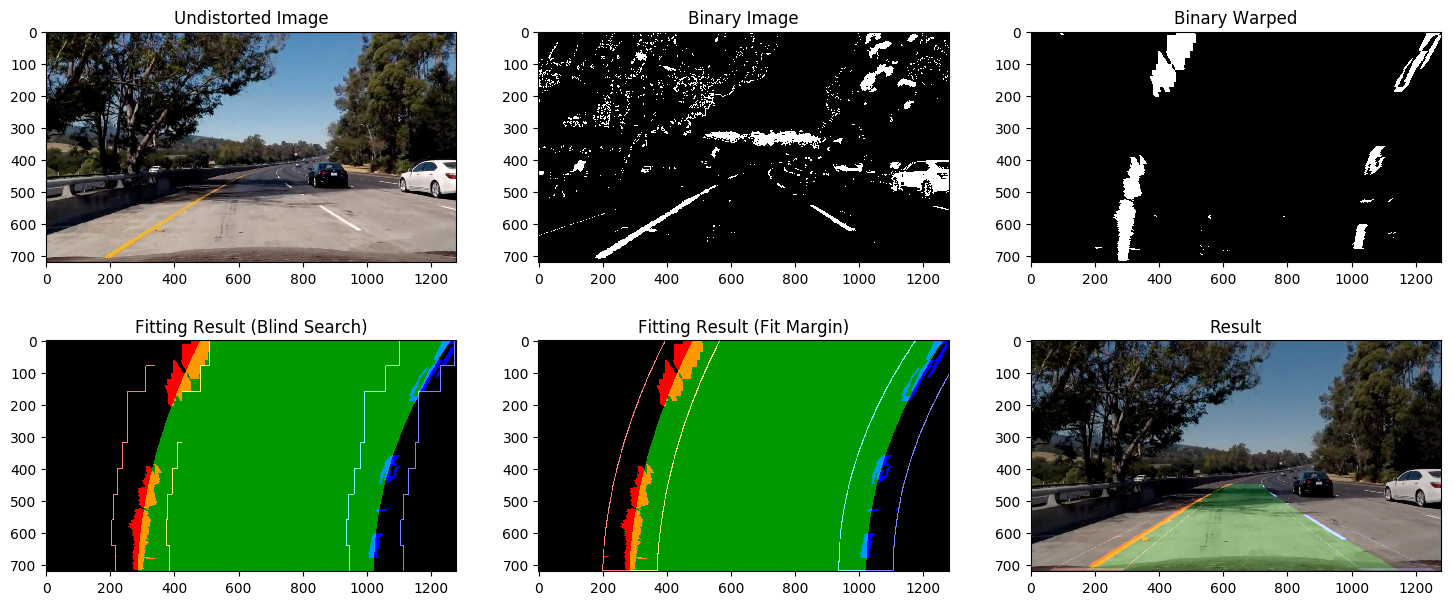

In [12]:
img = plt.imread('test_images/test5.jpg')

# Undistortion
undist_img = undistort(img)

# Binary filter
llf = LaneLineFilter()
binary = llf.apply(undist_img)

# Perspective Warp
wp = WarpPerspective()
binary_warped = wp.warp(binary)

plt.figure(figsize=(18, 7.5), dpi=100)
plt.subplot(2, 3, 1)
plt.imshow(undist_img)
plt.title('Undistorted Image')
plt.subplot(2, 3, 2)
plt.imshow(binary, 'gray')
plt.title('Binary Image')
plt.subplot(2, 3, 3)
plt.imshow(binary_warped, 'gray')
plt.title('Binary Warped')

# Locate line pixels by blind search method
ft = LaneLineFitTool()
line_points = ft.locate_lines_by_blind_search(binary_warped,
                                              make_margin_points=True)
fits = ft.polyfit(*line_points)
line_img = ft.line_points_visualize(*line_points, draw_margin=True)
area_img = ft.fit_area_visualize(*fits)
img_fit_warped = cv2.addWeighted(line_img, 1, area_img, 0.6, 0)

plt.subplot(2, 3, 4)
plt.imshow(img_fit_warped)
plt.title('Fitting Result (Blind Search)')

# Locate line pixels by fit margin.
line_points = ft.locate_lines_by_fit_margin(binary_warped, *fits,
                                            make_margin_points=True)
fits = ft.polyfit(*line_points)
line_img = ft.line_points_visualize(*line_points, draw_margin=True)
area_img = ft.fit_area_visualize(*fits)
img_fit_warped = cv2.addWeighted(line_img, 1, area_img, 0.6, 0)

plt.subplot(2, 3, 5)
plt.imshow(img_fit_warped)
plt.title('Fitting Result (Fit Margin)')

# Unwarp the fitting result to undistorted image.
img_fit = wp.warp_inv(img_fit_warped)        
out_img = cv2.addWeighted(undist_img, 0.8, img_fit, 0.3, 0)

plt.subplot(2, 3, 6)
plt.imshow(out_img)
plt.title('Result')

plt.savefig('fitting_example.jpg')
plt.show()

# Section 5: Pipline for Finding Lane Lines (Image)

In this section, I integrated the pipline of detecting lane lines from an image into one class. This pipline **only use blind search** method to locate lane lines. I applied this pipline to all test images, the results were perfect. Actually, for `project_video.mp4` only, this pipline is good enough to process most frames with perfect results.

---
The code cell below is the detailed implemented.

In [13]:
class LaneLineFinder4Image(object):
    
    def __init__(self, undist, linefilter, warper, fittool):
        self.undist = undist  # undistortion function
        self.lf = linefilter
        self.wp = warper
        self.ft = fittool
        # radius of curvature of the line in some units
        self.radius_of_curvature = None
        # distance in meters of vehicle center from the line
        self.center_deviation = None
    
    def apply(self, img):
        img_undist = self.undist(img)
        img_binary = self.lf.apply(img_undist)
        img_binary_warped = self.wp.warp(img_binary)

        line_points = self.ft.locate_lines_by_blind_search(img_binary_warped)
        fits = self.ft.polyfit(*line_points)
        area_img = self.ft.fit_area_visualize(*fits)
        line_img = self.ft.line_points_visualize(*line_points)
        
        img_fit_warped = cv2.addWeighted(line_img, 1, area_img, 0.6, 0)
        img_fit = self.wp.warp_inv(img_fit_warped)
        out_img = cv2.addWeighted(img_undist, 0.8, img_fit, 0.3, 0)

        fit_l, fit_r = self.ft.polyfit(*line_points)
        info = self.ft.cal_rad_and_cendev(fit_l, fit_r)
        self.radius_of_curvature = np.mean(info[0])
        self.center_deviation = info[1]
        
        if self.radius_of_curvature <= 1500:
            message0 = 'Line curve radius is about {:.1f}m.'.format(
                self.radius_of_curvature)
        else:
            message0 = 'Road is nearly straight.'
        if self.center_deviation >= 0:
            message1 = 'Your vehicle is {:.2f}m left from road center.'.format(
                self.center_deviation)
        else:
            message1 = 'Your vehicle is {:.2f}m right from road center.'.format(
                np.abs(self.center_deviation))
        cv2.putText(out_img, message0, (200, 100), 0, 1.2, (255, 255, 0), 2)
        cv2.putText(out_img, message1, (200, 150), 0, 1.2, (255, 255, 0), 2)
        
        return out_img

Two examples using `LaneLineFinder4Image`. The result seems perfect. And both line curvature radius and vehicle position on the road are presented with reasonable values.

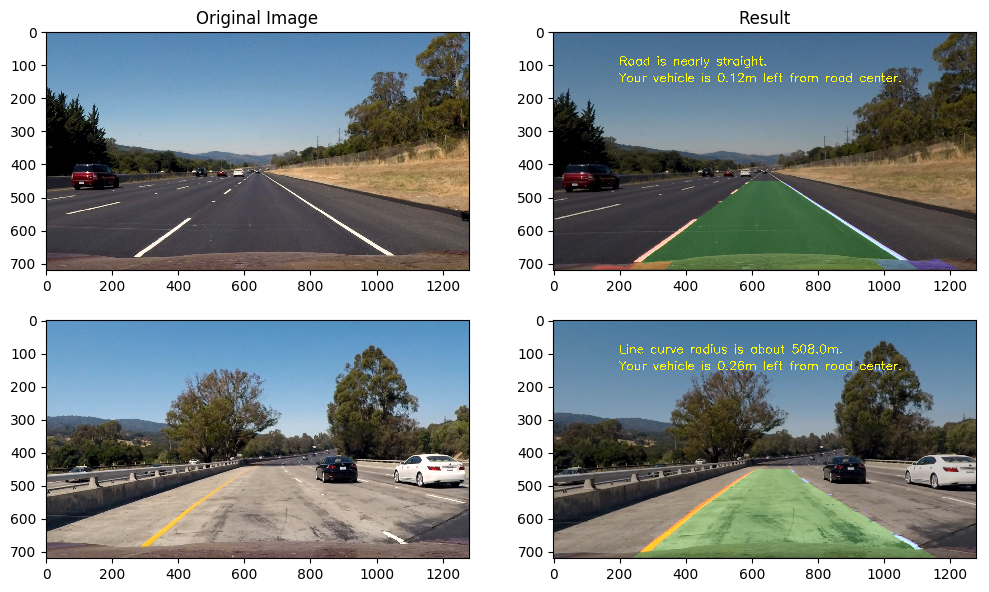

In [14]:
lf = LaneLineFilter()
wp = WarpPerspective()
ft = LaneLineFitTool()
linefinder = LaneLineFinder4Image(undistort, lf, wp, ft)

img0 = plt.imread('test_images/straight_lines2.jpg')
result0 = linefinder.apply(img0)
img1 = plt.imread('test_images/test1.jpg')
result1 = linefinder.apply(img1)

plt.figure(figsize=(12, 7), dpi=100)
plt.subplot(2, 2, 1)
plt.imshow(img0)
plt.title('Original Image')
plt.subplot(2, 2, 2)
plt.imshow(result0)
plt.title('Result')
plt.subplot(2, 2, 3)
plt.imshow(img1)
plt.subplot(2, 2, 4)
plt.imshow(result1)
plt.savefig('pipline_image_example.jpg')
plt.show()

## 5.1 Apply pipline to test images

Now apply `LaneLineFinder4Image` to all test images under `test_images/` directory.

In [15]:
test_img_paths = sorted(glob.glob('test_images/*.jpg'))

for test_img_path in test_img_paths:
    img = plt.imread(test_img_path)
    result = linefinder.apply(img)
    basename = os.path.basename(test_img_path)
    plt.imsave(os.path.join('output_images',
                            basename.split('.')[0]+'_output.jpg'), result)

## 5.2 Apply pipline to `project_video.mp4`

Apply `LaneLineFinder4Image` to `project_video.mp4`. The result is not bad!

In [16]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_out_0 = 'project_video_out_0.mp4'
clip = VideoFileClip("project_video.mp4")
white_clip = clip.fl_image(linefinder.apply) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_out_0, audio=False)

[MoviePy] >>>> Building video project_video_out_0.mp4
[MoviePy] Writing video project_video_out_0.mp4


100%|█████████▉| 1260/1261 [01:41<00:00, 12.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out_0.mp4 

CPU times: user 2min 16s, sys: 1.96 s, total: 2min 18s
Wall time: 1min 42s


Visualize the output video (also [link](project_video_out_0.mp4)).

In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_out_0))

## 5.3 Discussions

The `LaneLineFinder4Image` tool is not yet very stable when fitting dashed lane lines or lines are not clear. For a video, I need to design another lane line finder to take advantage of the frames as a sequence.

# Section 6: Pipline for Finding Lane Lines (Video)

In this section, I designed a tool to find lane lines in a video. The main steps are as below:
- Locate line pixels (by either blind search or fit margin, blind search in the first frame);
- Fit line pixels and check sanity, record good fits up to n records;
- When there are bad fits, use previous good fits;
- When too may bad fits (may lose track), relocate line pixel by blind search;
- Return averaged good fits over last n records.

---
Code implemention below.

In [18]:
class LaneLineFinder4Video(LaneLineFinder4Image):
    
    def __init__(self, n_recs=10, **kargs):
        super(LaneLineFinder4Video, self).__init__(**kargs)
        # the number of last records to be used.
        self.n_recs = n_recs
        
        # radius of curvature of the line in some units
        self.radius_of_curvature = None
        self.n_rads = deque(maxlen=self.n_recs)
        # distance in meters of vehicle center from the line
        self.center_deviation = None
        self.n_cendevs = deque(maxlen=self.n_recs)
        
        self.use_fit_margin = False
        
        self.n_good_fit = deque(maxlen=self.n_recs)
        self.n_good_fit_l = deque(maxlen=self.n_recs)
        self.n_good_fit_r = deque(maxlen=self.n_recs)
        
        # polynomial coefficients of last n fits
        self.n_fits_l = deque(maxlen=self.n_recs)
        self.n_fits_r = deque(maxlen=self.n_recs)
        # polynomial coefficients averaged over the last n iterations
        self.ave_fit_l = np.float32([0, 0, 300])
        self.ave_fit_r = np.float32([0, 0, 980])
        
        self.line_points = None
        
    def apply(self, img):
        img_undist = self.undist(img)
        img_binary = self.lf.apply(img_undist)
        img_binary_warped = self.wp.warp(img_binary)
        
        if self.use_fit_margin:
            self.line_points = self.ft.locate_lines_by_fit_margin(
                img_binary_warped, self.ave_fit_l, self.ave_fit_r)
        else:
            self.line_points = self.ft.locate_lines_by_blind_search(img_binary_warped)

        self.sanity_check_fit()
        
        area_img = self.ft.fit_area_visualize(self.ave_fit_l, self.ave_fit_r)
        line_img = self.ft.line_points_visualize(*self.line_points)
        
        img_fit_warped = cv2.addWeighted(line_img, 1, area_img, 0.6, 0)
        img_fit = self.wp.warp_inv(img_fit_warped)
        out_img = cv2.addWeighted(img_undist, 0.7, img_fit, 0.3, 0)
        
        info = self.ft.cal_rad_and_cendev(self.ave_fit_l, self.ave_fit_r)
        radius_of_curvature = np.min(info[0])
        self.n_rads.append(radius_of_curvature)
        self.radius_of_curvature = np.mean(self.n_rads)
        center_deviation = info[1]
        self.n_cendevs.append(center_deviation)
        self.center_deviation = np.mean(self.n_cendevs)
        
        if self.radius_of_curvature <= 1500:
            message0 = 'Line curve radius is about {:.1f}m.'.format(
                self.radius_of_curvature)
        else:
            message0 = 'Road is nearly straight.'
        if self.center_deviation >= 0:
            message1 = 'Your vehicle is {:.2f}m left from road center.'.format(
                self.center_deviation)
        else:
            message1 = 'Your vehicle is {:.2f}m right from road center.'.format(
                np.abs(self.center_deviation))
        cv2.putText(out_img, message0, (200, 100), 0, 1.2, (255, 255, 0), 2)
        cv2.putText(out_img, message1, (200, 150), 0, 1.2, (255, 255, 0), 2)
        
        return out_img
    
    def sanity_check_fit(self):
        '''
        Checking that they have similar curvature, 
        separated by approximately the right distance horizontally 
        and roughly parallel.
        '''
        # check fit params
        
        xl, yl, xr, yr = self.line_points
        if len(xl) > 0:
            fit_l = np.polyfit(yl, xl, 2)
        else:
            fit_l = self.ave_fit_l
        if len(xr) > 0:
            fit_r = np.polyfit(yr, xr, 2)
        else:
            fit_r = self.ave_fit_r
        
        if len(self.n_fits_l) == 0: self.n_fits_l.append(fit_l)
        if len(self.n_fits_r) == 0: self.n_fits_r.append(fit_r)
        
        good_a_diffs = np.abs(fit_l[0] - fit_r[0]) < 4e-4
        good_b_diffs = np.abs(fit_l[1] - fit_r[1]) < 0.4
        good_pos = (-100 < fit_l[2] < 740) and (540 < fit_r[2] < 1380)
        good_c_diffs = 500 < (fit_r[2] - fit_l[2]) < 1000
        
        if good_a_diffs and good_b_diffs and good_pos and good_c_diffs:
            self.good_fit = True
            self.use_fit_margin = True
            self.n_fits_l.append(fit_l)
            self.n_fits_r.append(fit_r)
        else:
            self.good_fit = False
        self.n_good_fit.append(self.good_fit)
        if np.mean(self.n_good_fit) <= 0.3:
            self.use_fit_margin = False
            
        self.ave_fit_l = np.mean(np.array(self.n_fits_l), axis=0)
        self.ave_fit_r = np.mean(np.array(self.n_fits_r), axis=0)
    

## 6.1 Apply pipline to `project_video.mp4`

I am excited to say that the output video of `project_video.mp4` seems perfect! ^_^

In [19]:
lf = LaneLineFilter()
wp = WarpPerspective()
ft = LaneLineFitTool()
linefinder = LaneLineFinder4Video(undist=undistort, linefilter=lf,
                                  warper=wp, fittool=ft)

video_out_1 = 'project_video_out.mp4'
clip = VideoFileClip('project_video.mp4')
white_clip = clip.fl_image(linefinder.apply)
%time white_clip.write_videofile(video_out_1, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [01:34<00:00, 13.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 2min 9s, sys: 1.71 s, total: 2min 11s
Wall time: 1min 35s


Visualize the output video (also [link](project_video_out.mp4)).

In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_out_1))

## 6.2 Apply pipline to `challenge_video.mp4`

This video have a different perspective. The pipeline correctly mapped out curved lines and passed shadows regions.

In [21]:
img_size = (1280, 720)
src = np.float32(
    [[(img_size[0] / 2) - 75, img_size[1] / 2 + 120],
     [0, img_size[1]],
     [img_size[0], img_size[1]],
     [(img_size[0] / 2) + 100, img_size[1] / 2 + 120]])
dst = np.float32(
    [[img_size[0] / 8, 0],
     [img_size[0] / 8, img_size[1]],
     [img_size[0] * 7/8, img_size[1]],
     [img_size[0] * 7/8, 0]])

lf = LaneLineFilter()
wp = WarpPerspective(src=src, dst=dst)
ft = LaneLineFitTool(ym_per_pix=28/720)
linefinder = LaneLineFinder4Video(undist=undistort, linefilter=lf,
                                  warper=wp, fittool=ft)

video_out_2 = 'challenge_video_out.mp4'
clip = VideoFileClip("challenge_video.mp4")
white_clip = clip.fl_image(linefinder.apply) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_out_2, audio=False)

[MoviePy] >>>> Building video challenge_video_out.mp4
[MoviePy] Writing video challenge_video_out.mp4


100%|██████████| 485/485 [00:35<00:00, 13.70it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_out.mp4 

CPU times: user 48.8 s, sys: 916 ms, total: 49.7 s
Wall time: 35.7 s


Visualize the output video (also [link](challenge_video_out.mp4)).

In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_out_2))

# Section 7: Discussions

The `LaneLineFinder4Video` has done a good job on both `project_video.mp4` and `challenge_video.mp4`. However, `harder_challenge_video.mp4` is beyond the ability of my pipline. In the future, I may try to use DL image segmentation methods to tackle the big challenge.